In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
# 데이터 로드 및 전처리 함수
def load_data(dataset_path, image_size=(224, 224)):
    X = []
    Y = []
    files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]
    for file in files:
        try:
            parts = file.split('_')
            if len(parts) >= 4:
                gender = int(parts[1])
                img_path = os.path.join(dataset_path, file)
                img = load_img(img_path, target_size=image_size)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)  # VGG16 전처리 사용
                X.append(img_array)
                Y.append(gender)
        except Exception as e:
            print(f"이미지 로딩 오류: {file}, 에러: {e}")
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [ ]:
# 데이터셋 압축 해제
zip_path = '/content/UTKFace.zip'  # 직접 업로드한 ZIP 파일의 경로
unzip_path = '/content/UTKFace'

if not os.path.exists(unzip_path):
    os.makedirs(unzip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print("압축 해제 완료")

압축 해제 완료


In [ ]:
# 전이 학습을 이용한 모델 구축 함수
def build_gender_model(base_model):
    base_model.trainable = False  # 기본 모델 고정
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
# 데이터셋 경로 설정
dataset_path = '/content/UTKFace/UTKFace'
X, Y = load_data(dataset_path)

# 데이터셋을 훈련, 검증, 테스트 세트로 분할
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [ ]:
# VGG16을 기본 모델로 사용
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

# 모델 생성, 컴파일, 훈련
model = build_gender_model(base_model)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=10)

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
445/445 [==============================] - 25s 44ms/step - loss: 0.6738 - accuracy: 0.7495 - val_loss: 0.3738 - val_accuracy: 0.8464
Epoch 2/10
445/445 [==============================] - 14s 31ms/step - loss: 0.4362 - accuracy: 0.8168 - val_loss: 0.3414 - val_accuracy: 0.8559
Epoch 3/10
445/445 [==============================] - 14s 31ms/step - loss: 0.3699 - accuracy: 0.8391 - val_loss: 0.3340 - val_accuracy: 0.8585
Epoch 4/10
445/445 [==============================] - 14s 31ms/step - loss: 0.3423 - accuracy: 0.8554 - val_loss: 0.3369 - val_accuracy: 0.8561
Epoch 5/10
445/445 [==============================] - 14s 32ms/step - loss: 0.3196 - accuracy: 0.8621 - val_loss: 0.3165 - val_accuracy: 0.8629
Epoch 6/10
445/445 [==============================] - 14s 32ms/step - loss: 0.3118 - accuracy: 0.8667 - val_loss: 0.3161 - val_accuracy: 0.8640
Epoch 7/10
445/445 [==============================] - 14s 31ms/step - l

In [ ]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"테스트 손실: {test_loss}, 테스트 정확도: {test_accuracy}")

149/149 [==============================] - 3s 23ms/step - loss: 0.3008 - accuracy: 0.8734
테스트 손실: 0.30083295702934265, 테스트 정확도: 0.8734444379806519


149/149 [==============================] - 3s 21ms/step


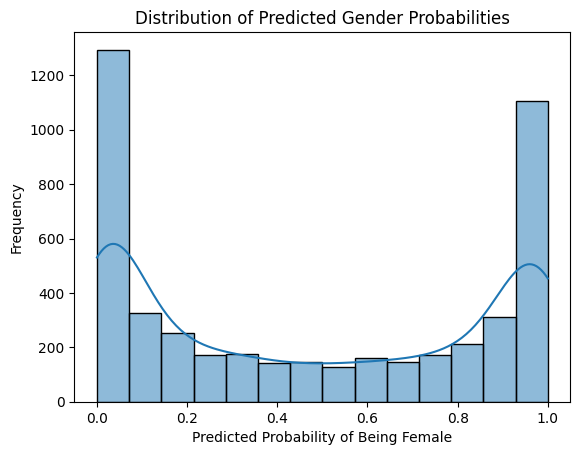

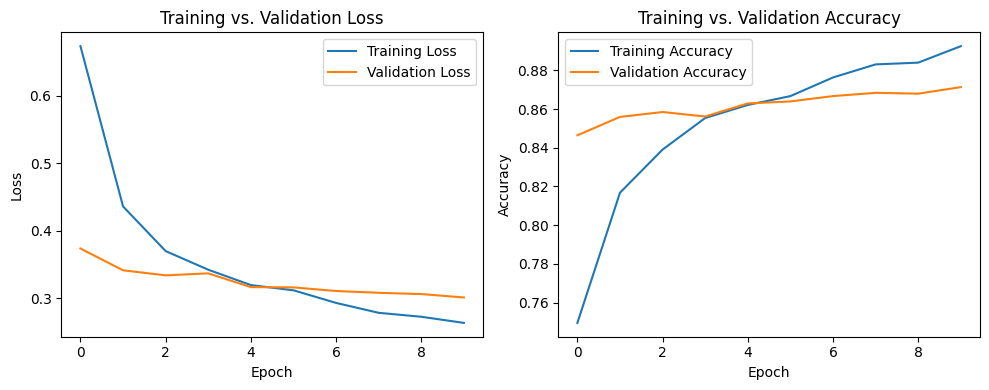

In [ ]:
# 예측 결과 및 성능 시각화
predictions = model.predict(X_test).flatten()
sns.histplot(predictions, kde=True)
plt.title('Distribution of Predicted Gender Probabilities')
plt.xlabel('Predicted Probability of Being Female')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 모델 저장
model_save_path = '/content/gender_model_alpha.h5'
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
